PDHG algorithm

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
from modopt.math.metrics import ssim

import numpy as np
import matplotlib.pyplot as plt

## Import data and add noise

### Fourier operator and noise

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(np.real(u0.data))+s*np.random.randn(2*n*n).view(np.complex128)
u0_mat = np.asarray(u0)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Operators

In [37]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data

p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

new_loc = kspace_loc[np.where(p)]
#pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

#Wavelet
linear_op = WaveletN(wavelet_name="db8",nb_scale=4,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

In [7]:
#ifft on noised data = base result
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.6633419212432164


In [38]:
linear_op.op(u0_mat).shape

(262144,)

## Reconstruction

In [8]:
# Specific files import
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import f1,f2,g

In [49]:
param = {"zeta":1e15,"pn1":2e-6,"epsilon":1e-1,"gamma":1e-10}

In [40]:
print(g(u0_mat,param["zeta"],param["epsilon"]),f2(linear_op.op(u0_mat),param["pn1"],param["gamma"]))

1.9073484054388313e-07 2.296999543905258e-07


In [50]:
# -- Solving --
# myconst = {"sigma":1.15,"tau":0.43}
uk,norms,energy = pdhg(y,p,fourier_op,linear_op,param)

10  iterations:
Cost: 3.742106918147298e-07 
Norm: 0.1574793058507964 

20  iterations:
Cost: 3.435809816713808e-07 
Norm: 0.11776669248834556 

30  iterations:
Cost: 3.2864884163031623e-07 
Norm: 0.08470109092200676 

40  iterations:
Cost: 3.2021433954569335e-07 
Norm: 0.06161881231022997 

50  iterations:
Cost: 3.148620079192484e-07 
Norm: 0.04497430372748097 

60  iterations:
Cost: 3.111878456362412e-07 
Norm: 0.033200797746210674 

70  iterations:
Cost: 3.0852163011453696e-07 
Norm: 0.02528844919929828 

80  iterations:
Cost: 3.065129289570737e-07 
Norm: 0.020489123971811116 

90  iterations:
Cost: 3.0497111347327825e-07 
Norm: 0.01654129140574036 

100  iterations:
Cost: 3.0376803276666353e-07 
Norm: 0.013749618515835865 

110  iterations:
Cost: 3.028219590940606e-07 
Norm: 0.011661263301705435 

120  iterations:
Cost: 3.0207071338515043e-07 
Norm: 0.009908519363395407 

130  iterations:
Cost: 3.014683206471531e-07 
Norm: 0.008602026126943725 

140  iterations:
Cost: 3.00983797770

In [51]:
#Showing
print(ssim(u0_mat,uk))
pysap.Image(data = np.real(uk)).show()

0.8820393195738303


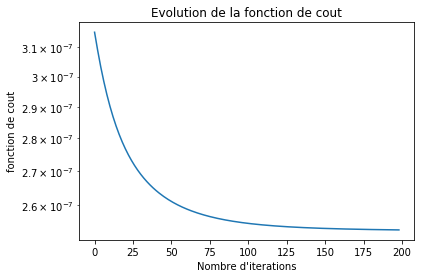

In [30]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Nombre d'iterations")
plt.ylabel("fonction de cout")
plt.title("Evolution de la fonction de cout")
plt.yscale("log")

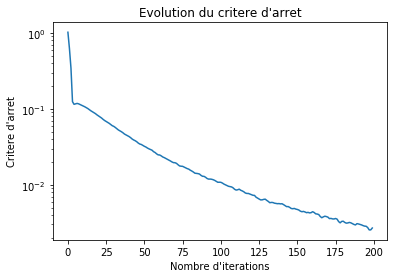

In [31]:
plt.plot(norms)
plt.yscale("log")
plt.xlabel("Nombre d'iterations")
plt.ylabel("Critere d'arret")
plt.title("Evolution du critere d'arret")
plt.yscale("log")

## Condat-Vu L1

In [56]:
from modopt.opt.proximity import SparseThreshold

regularizer_op = SparseThreshold(linear_op, 1e-6, thresh_type="soft")
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=p*y,
    optimization_alg='condatvu',
    num_iterations=200,
)

Lipschitz constant is 1.0999999999999786
The lipschitz constraint is satisfied
 - mu:  1e-06
 - lipschitz constant:  1.0999999999999786
 - tau:  0.9523809433106676
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f354a9be080> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (262144,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:01:40 Time:  0:01:40


 - final iteration number:  200
 - final cost value:  9.108310749485707e-08
 - converged:  True
Done.
Execution time:  804.6685800000014  seconds
----------------------------------------


In [58]:
print(ssim(uk,np.abs(x_final)))
pysap.Image(data=np.abs(x_final)).show()

0.9309132920990283
